In [18]:
from binder_diblock_vertex_competitive import *
from binder_diblock_gamma234_vertex import *
from itertools import permutations as perms
from itertools import product
import numpy as np
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.optimize import basinhopping
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
# load s2 mat
# find k_star mat
# for each mu1, mu2, calc free eenergy at kstar, find min phase, store in array
# visulaize stores

In [3]:
# # ID = 9987.64006
# ID = 9995.64006
# # ID = 9997.64006
ID = 10001.04006

# looping = "full mark dens comp alt f_bind,"

settings = np.load(r"C:\Users\tmhab\wlcsim_membrane\binder_diblock\ID=%s_settings.npy" % (ID), allow_pickle = True)

[chrom, [klog_min, klog_max, klog_num]] = settings

[n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

[pa_vec, marks_2] = poly_marks

mu1_array = np.arange(mu_min, mu_max, del_mu)
mu2_array = np.arange(mu_min, mu_max, del_mu)

k_vec = np.logspace(klog_min, klog_max, klog_num) / b
  
s2_mats = np.load(r"C:\Users\tmhab\wlcsim_membrane\binder_diblock\ID=%s_chrom_s2_mats_v_int=[[%s,%s],[%s,%s]],diblock,mu_max=%s.npy"\
                 % (ID, v_int[0,0], v_int[0,1], v_int[1,0], v_int[1,1], mu_max), allow_pickle = True)

s_bind_A_arr = np.load(r"ID=%s_s_bind_A.npy" % ID, allow_pickle=True)
s_bind_B_arr = np.load(r"ID=%s_s_bind_B.npy" % ID, allow_pickle=True)
spacing = int(1 / del_mu)

In [4]:
%%time
# K STAR stab anal NUMBER DENSITY THEORY

# poly solv
# chi = 0.00083
# chi = 3/N
# chi = 2/N

# full soln
# chi = 0.00005828
# chi = -1.0
chi = 0

min_eigval_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))
# min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))

min_eigval_arr_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)))


S2_det_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

S2_cond_arr_soln_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_soln_1 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))
# S2_cond_arr_melt_2 = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec[:])))

max_cond_arr_allk = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

min_eigval_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
min_eigval_arr_allk_ps = np.zeros((len(mu1_array[:]), len(mu2_array[:])))
# min_eigval_arr_allk_DENS_melt = np.zeros((len(mu1_array[:]), len(mu2_array[:])))

# min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec)), dtype = object)
# min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:])), dtype = object)

min_eigvec_arr = np.zeros((len(mu1_array[:]), len(mu2_array[:]), len(k_vec), 3))
min_eigvec_arr_allk_DENS = np.zeros((len(mu1_array[:]), len(mu2_array[:]), 3))

k_star_arr_DENS= np.zeros((len(mu1_array[:]), len(mu2_array[:]))) 


avo = 6.02e23 # num / mol
dens_p = 1 # g/cm^3
mol_weight_p = 1e5 # g/mol

rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3
n_p = 1e8 
# A = 1/(b) # nm^2 cross sectional area
# vol_nuc = A*(b) # volume of nucleosome

# vol_solv = 1#N #1#10000000**3# (4e-10)**3

# s2_mats = s2_mat_shlk_dens
for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
#         if mu1 == mu2:
#             continue
        mu = [mu1, mu2]
#         print("mu: ", mu)

        for ik, k in enumerate(k_vec):
#             S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
#                             [0, ss*N**2, 0, 0], \
#                             [cg1[0], 0, g1g1[0], g1g2[0]],\
#                             [cg2[0], 0, g2g1[0], g2g2[0]]])

            S2_mat =  s2_mats[i][j][ik].copy()

            
            # EDIT  2. goal is 1/V * (N**2 * 1/N**2) = rho_c / (M * np)
            # in code sfs defined as S =N**2 * 1/N**2 ~integral~. 
            # then in sf_mats multiply facotr of rho_c / N^2. overall prefacotr is rho_c/N^2
            # To get to goal, must multiply by (N_m^2 * M)/np
            S2_mat *= (N_m**2 * M)/n_p
            S2_mat[1][1] /= (N_m**2 * M)/n_p
            # print(S2_mat)

            
            
# #            # TESTING DIF MAGNITUDES OF RHO_S
#             rho_s_test = rho_s * 10000# 1e-5#33#1e5
#             S2_mat[1][1] = rho_s_test 
            
#             # if phi_c >= 0.999:
#             #     raise Exception("melt!")

#            # TESTING DIF MAGNITUDES of RHO_P
            # #print("CHANGED RHO_C!!!!!!!")
            # rho_c_test = rho_c / 10000
            rho_c_test = rho_p
            S2_mat /= rho_c
            S2_mat *= rho_c_test
            S2_mat[1][1] *= (rho_c/rho_c_test)



            
            # FULL SOLUTION, 2 reader proteins
            S2_det = np.linalg.det(S2_mat)
#             S2_det_arr[i][j][ik] = S2_det
            # print("S2 det: ", S2_det)
            # print("---------------------------------------")
            S2_cond = np.linalg.cond(S2_mat)
            S2_cond_arr_soln_2[i][j][ik] = S2_cond
            
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)

#                 G2 = (1/N)* np.array([[S2_inv[0,0] - 2*chi*N + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + N*v_int[0,0], S2_inv[2,3] + N*v_int[0,1]],\
#                    [S2_inv[3,0], S2_inv[3,2] + N*v_int[1,0], S2_inv[3,3] + N*v_int[1,1]]])  # ORIGINAL (no int vol)

                #CORRECT (using interaction volume term)
                G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
                   [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]*Vol_int, S2_inv[2,3] + v_int[0,1]*Vol_int],\
                   [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]*Vol_int, S2_inv[3,3] + v_int[1,1]*Vol_int]])

#                 # testing chi_12
#                 chi_12 = 100#v_int[1,0] - ( (v_int[0,0] + v_int[1,1])/2 )
#                 G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + 0*Vol_int, S2_inv[2,3] + chi_12*Vol_int],\
#                    [S2_inv[3,0], S2_inv[3,2] + chi_12*Vol_int, S2_inv[3,3] + 0*Vol_int]])
            
# #                 testing v_c
#                 G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#                    [S2_inv[2,0], S2_inv[2,2] + -2*Vol_int, S2_inv[2,3] + 2*Vol_int],\
#                    [S2_inv[3,0], S2_inv[3,2] + 2*Vol_int, S2_inv[3,3] + -2*Vol_int]])
                
                val, vec = np.linalg.eigh(G2)
                vec = vec.T
#                 print(vec)
#                 print(vec.T)
#                 print(val)
                min_val = np.min(val)            
                min_eigval_arr[i][j][ik] = min_val
                min_eigvec_arr[i][j][ik] = vec[np.where(val == min_val)]

            # POLY/SOLV only
            S2_mat = np.array([[S2_mat[0,0], 0], [0, S2_mat[1,1]]])

#             if phi_c >= 0.999:
#                 raise Exception("melt!")
            S2_det = np.linalg.det(S2_mat)           
            
            if S2_det != 0:# and S2_cond < 1e10:
                S2_inv = np.linalg.inv(S2_mat)

#                 G2 = (1/N)* np.array([S2_inv[0,0] - 2*chi*N + S2_inv[1,1]]) # original
                
                G2 = np.array([S2_inv[0,0] - 2*chi + S2_inv[1,1]])

                val = G2[0]
#                 min_val = np.min(val)            
                min_eigval_arr_ps[i][j][ik] = val


        # all-k analysis
        min_vals = min_eigval_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])] # min eigvals at mu1,mu2 for each k
        
        min_vecs = min_eigvec_arr[i][j][:][np.nonzero(min_eigval_arr[i][j][:])]
        if len(min_vals) != 0:
            minval_allk = np.min(min_vals) # minimum eigenvalue at mu1,mu2 across all ks
#             print(minval_allk)
            min_eigval_arr_allk_DENS[i][j] = minval_allk
            
            min_eigvec_arr_allk_DENS[i][j] = min_vecs[np.where(min_vals==minval_allk)]#[0][0] #double zero if saving as objects
            
            k_star = k_vec[np.where(min_vals==minval_allk)] # corresponding k 
#             print(k_star)
            k_star_arr_DENS[i][j] = k_star

            
        min_vals_ps = min_eigval_arr_ps[i][j][:][np.nonzero(min_eigval_arr_ps[i][j][:])] # min eigvals at mu1,mu2 for each k
#         if len(min_vals_ps) != 0:
#             minval_allk = np.min(min_vals_ps) # minimum eigenvalue at mu1,mu2 across all ks
        min_eigval_arr_allk_ps[i][j] = np.min(min_vals_ps)
            
#         min_vals_melt = min_eigval_arr_melt[i][j][:] # min eigvals at mu1,mu2 for each k
#         minval_allk_melt = np.min(min_vals_melt) # minimum eigenvalue at mu1,mu2 across all ks
#         min_eigval_arr_allk_DENS_melt[i][j] = minval_allk_melt

        cond_nums = S2_cond_arr_soln_2[i][j][:]
        max_cond_allk = np.max(cond_nums)
        max_cond_arr_allk[i][j] = max_cond_allk
        

# setting all non-decomposed/ separated systems to 0 
poly_fluc = min_eigvec_arr_allk_DENS[:,:,0]
poly_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot1_fluc = min_eigvec_arr_allk_DENS[:,:,1]
prot1_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

prot2_fluc = min_eigvec_arr_allk_DENS[:,:,2]
prot2_fluc[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = 0

k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = -1 # unphysical value, to indicate outside of spinodal

CPU times: total: 78.1 ms
Wall time: 734 ms


In [ ]:
# %%time
phases = np.zeros((len(mu1_array[:]), len(mu2_array[:]))) - 1 
for i, mu1 in enumerate(mu1_array[:]):
    for j, mu2 in enumerate(mu2_array[:]):
        print("mu: ", mu1, mu2)
        q_star = k_star_arr_DENS[i,j]
        if q_star == -1:
            phases[i,j] = 0 # disordered phase
        elif q_star == k_vec[0]:
            phases[i,j] = 1 # macrophase sep
        else: #microphse sep
            # print(q_star)
            s_bnd_A = s_bind_A_arr[i,j,:]
            s_bnd_B = s_bind_B_arr[i,j,:]
            
            lam_q = q_star*np.array([1, 0, 0])

            cyl_q1 = q_star*np.array([1, 0, 0])
            cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
            cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
            cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
            
            bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
            bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
            bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
            bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
            bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
            bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])
            
            
            lam_g3 = 0
            G3 = gamma3(chrom, s_bnd_A, s_bnd_B, cyl_qs) # all g3s are eqivlaent
            cyl_g3 = (1/6)  * (1/(3*np.sqrt(3))) * 12 * G3#
            bcc_g3 = (4/(3*np.sqrt(6))) * G3
            
            G4_00 = gamma4(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]))
            lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))        
            
            cyl_g4 = (1/24) * (1/9) *(18*G4_00 + \
              72*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])) )
            
            bcc_g4 = (1/24)* (G4_00 \
                     + 8*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
                     + 2*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
                     + 4*gamma4(chrom, s_bnd_A, s_bnd_B, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )
            
            lam_g2 = (1/2) * 2 * (1) * gamma2(chrom, s_bnd_A, s_bnd_B, q_star, chi)
            cyl_g2 = lam_g2
            bcc_g2 = lam_g2
            
            # amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
            #                               1, disp=False)
            initial = [0, 0, 0] # poly, A, B
            # in_bcc = 0
            
            amps_l = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", lam_g2, amps, amps) \
                                               +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps, amps, amps, amps)), initial, disp=False)
            
            lamF = np.real( np.einsum("ij,i,j ->", lam_g2, amps_l, amps_l) \
                                            +  np.einsum("ijkl,i,j,k,l ->", lam_g4, amps_l, amps_l, amps_l, amps_l))
            
            amps_cy = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", cyl_g2, amps, amps) \
                                                + np.einsum("ijk,i,j,k ->", cyl_g3, amps, amps, amps) \
                                               +  np.einsum("ijkl,i,j,k,l ->", cyl_g4, amps, amps, amps, amps)), initial, disp=False)
            
            cylF = np.real(np.einsum("ij,i,j ->", cyl_g2, amps_cy, amps_cy) \
                                                + np.einsum("ijk,i,j,k ->", cyl_g3, amps_cy, amps_cy, amps_cy) \
                                                + np.einsum("ijkl,i,j,k,l ->", cyl_g4, amps_cy, amps_cy, amps_cy, amps_cy))

            amps_bcc = optimize.fmin(lambda amps: np.real(np.einsum("ij,i,j ->", bcc_g2, amps, amps) \
                                                + np.einsum("ijk,i,j,k ->", bcc_g3, amps, amps, amps) \
                                               +  np.einsum("ijkl,i,j,k,l ->", bcc_g4, amps, amps, amps, amps)), initial, disp=False)
            
            bccF = np.real(np.einsum("ij,i,j ->", bcc_g2, amps_bcc, amps_bcc) \
                                                + np.einsum("ijk,i,j,k ->", bcc_g3, amps_bcc, amps_bcc, amps_bcc) \
                                                + np.einsum("ijkl,i,j,k,l ->", bcc_g4, amps_bcc, amps_bcc, amps_bcc, amps_bcc))

            minF = np.min([lamF, cylF, bccF, 0])

            if minF == 0:
                raise Exception("phase sep not stable in spinodla??")
            elif minF == lamF:
                phases[i,j] = 2
            elif minF == cylF:
                phases[i,j] = 3
            elif minF == bccF:
                phases[i,j] = 4
    
            # amp_l1, amp_l2 = optimize.fmin(lambda amps: np.real(amps[0]**2 * lam_g2 + amps[0]**3 * lam_g3 + amps[0]**4 * lam_g4 + \
            #                                                 amps[1]**2 * lam_g2_2 + amps[1]**3 * lam_g3_2 + amps[1]**4 * lam_g4_2 + \
            #                                                 amps[0]**2 * amps[1] * lam_g3_mix + amps[0]**2 * amps[1]**2 * lam_g4_mix), \
            #                       initial, disp=False)            

mu:  -5.0 -5.0
mu:  -5.0 -4.5
mu:  -5.0 -4.0
mu:  -5.0 -3.5
mu:  -5.0 -3.0
mu:  -5.0 -2.5


In [ ]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


min_ind = 0
max_ind = -1

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
#     poly_fluc = min_eigvec_arr_allk[:,:,0]
#     poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot1_fluc = min_eigvec_arr_allk[:,:,1]
#     prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot2_fluc = min_eigvec_arr_allk[:,:,2]
#     prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0
    
# k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
# ax = sns.heatmap(1/(k_star_arr*b), linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
ax = sns.heatmap(phases, linewidth=0.25, cmap = "rainbow", xticklabels=mu2_array[min_ind:max_ind], yticklabels=mu1_array[min_ind:max_ind],\
                 cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"phases" +  ", $\chi = $" + \
          str(np.round(chi, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")


plt.show()

<Figure size 640x480 with 0 Axes>

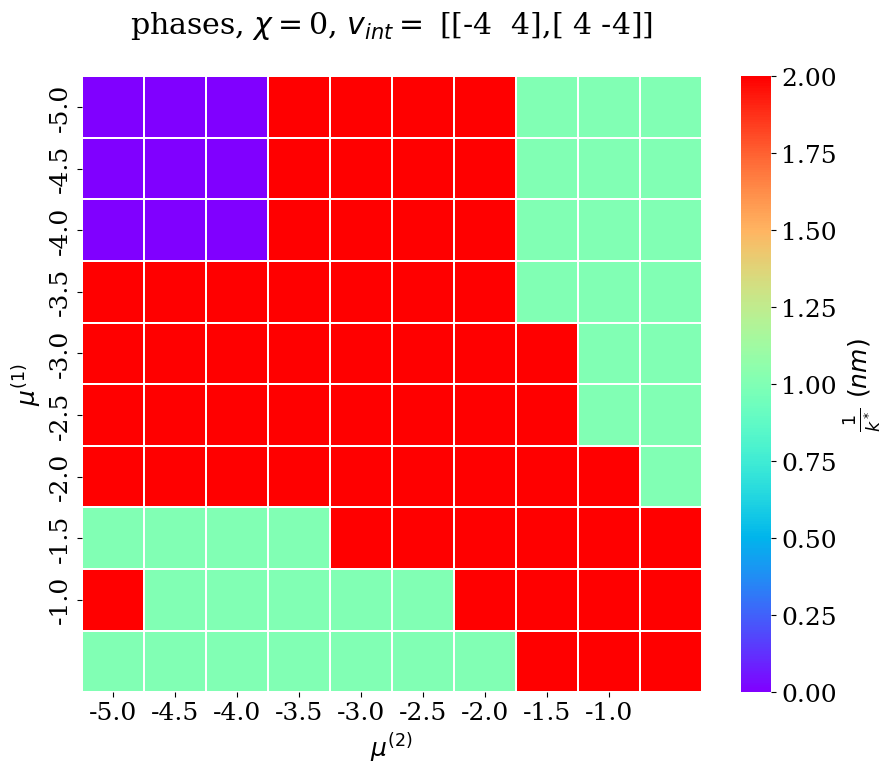

In [24]:
fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)


min_ind = 0
max_ind = -1

# plt.scatter(mu1_array[np.where(multi_soln_mus == 1)[0]],mu2_array[np.where(multi_soln_mus == 1)[1]])
# k_ind = 20
#     poly_fluc = min_eigvec_arr_allk[:,:,0]
#     poly_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot1_fluc = min_eigvec_arr_allk[:,:,1]
#     prot1_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0

#     prot2_fluc = min_eigvec_arr_allk[:,:,2]
#     prot2_fluc[np.where(np.sign(min_eigval_arr_allk) == 1) ] = 0
    
# k_star_arr_DENS[np.where(np.sign(min_eigval_arr_allk_DENS) == 1) ] = np.nan
# ax = sns.heatmap(1/(k_star_arr*b), linewidth=0.25, cmap = "cool", xticklabels=mu2_array, yticklabels=mu1_array, cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
ax = sns.heatmap(phases, linewidth=0.25, cmap = "rainbow", xticklabels=mu2_array[min_ind:max_ind], yticklabels=mu1_array[min_ind:max_ind],\
                 cbar_kws={'label':  r"$ \frac{1}{k^*} \ (nm)$"})
plt.ylabel("$\mu^{(1)}$")
plt.xlabel("$\mu^{(2)}$")
plt.title(r"phases" +  ", $\chi = $" + \
          str(np.round(chi, 2)) \
          +  ", $v_{int} = $ [" + str(v_int[0]) + "," + str(v_int[1]) + "]" +\
          "\n")


plt.show()

In [ ]:
# %%time
# #SINGLE WAVEMODE PHASE DIAGRAM 
# N = 10000

# # fa_array = np.arange(0.3, 0.501, 0.01)#[0.3, 0.325, 0.35, 0.375, 0.3875, 0.4, 0.4125, 0.425, 0.4375, 0.45, 0.475, 0.5]#[0.3, 0.35, 0.4, 0.45, 0.5]#np.arange(0.2, 0.51, .02)
# chi_array = np.arange(8, 25, .01)/N#np.arange(5, 30, 0.5)/N #np.array([5, 7, 10, 12, 15, 17, 20])/N #* N

# N_m = 1000
# b = 1
# M = 10

# fa_array = [0.3, 0.4, 0.5, 0.6, 0.7]
# # poly_type = "diblock"
# # n_p = 1


# lam_pnts = np.array([])
# cyl_pnts = np.array([])
# bcc_pnts = np.array([])
# gyr_pnts = np.array([])
# sq_cyl_pnts = np.array([])
# sim_cub_pnts = np.array([])
# fcc_pnts = np.array([])
# dis_pnts = np.array([])

# for FA in fa_array:
#     poly_mat, dens = poly_mat_gen(poly_type, M, n_p, FA) 
    
#     q_star = spinodal_gaus(poly_mat, dens, N_m, b, M)
#     q_star = q_star[0]
    
#     lam_q = q_star*np.array([1, 0, 0])
    
#     cyl_q1 = q_star*np.array([1, 0, 0])
#     cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
#     cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
#     cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])
    
#     bcc_q1 = 2**(-0.5)*q_star*np.array([1,1,0])
#     bcc_q2 = 2**(-0.5)*q_star*np.array([-1,1,0])
#     bcc_q3 = 2**(-0.5)*q_star*np.array([0,1,1])
#     bcc_q4 = 2**(-0.5)*q_star*np.array([0,1,-1])
#     bcc_q5 = 2**(-0.5)*q_star*np.array([1,0,1])
#     bcc_q6 = 2**(-0.5)*q_star*np.array([1,0,-1])
    
#     sq_6 = (1/np.sqrt(6)) * q_star
#     gyr_q1 = sq_6*np.array([-1, 2, 1])
#     gyr_q2 = sq_6*np.array([2, 1, -1])
#     gyr_q3 = sq_6*np.array([1, -1, 2])
#     gyr_q4 = sq_6*np.array([2, -1, -1])
#     gyr_q5 = sq_6*np.array([-1, 2, -1])
#     gyr_q6 = sq_6*np.array([-1, -1, 2])
    
#     gyr_q7 = sq_6*np.array([2, 1, 1])
#     gyr_q8 = sq_6*np.array([1, 2, 1])
#     gyr_q9 = sq_6*np.array([1, 1, 2])
#     gyr_q10 = sq_6*np.array([2, -1, 1])
#     gyr_q11 = sq_6*np.array([1, 2, -1])
#     gyr_q12 = sq_6*np.array([-1, 1, 2])

#     sq_cyl_q1 = q_star * np.array([1,0,0])
#     sq_cyl_q2 = q_star * np.array([0,1,0])
    
#     sim_cub_q1 = q_star * np.array([1,0,0])
#     sim_cub_q2 = q_star * np.array([0,1,0])
#     sim_cub_q3 = q_star * np.array([0,0,1])
    
#     fcc_q1 = 3**(-0.5)*q_star*np.array([1,1,1])
#     fcc_q2 = 3**(-0.5)*q_star*np.array([1,1,-1])
#     fcc_q3 = 3**(-0.5)*q_star*np.array([1,-1,1])
#     fcc_q4 = 3**(-0.5)*q_star*np.array([-1,1,1])
    
    
#     G3 = gamma3_E(poly_mat, dens, N_m, b, M, cyl_qs) # all g3s are eqivlaent
#     lam_g3 = 0
#     cyl_g3 = -(1/6) * (1/(3*np.sqrt(3))) * 12 * G3
#     bcc_g3 = -(4/(3*np.sqrt(6))) * G3 #* gamma3_E(poly_mat, dens, N_m, b, M, np.array([bcc_q6, bcc_q3, -bcc_q1]))
#     gyr_g3 = -(1/6)  * (1/(12*np.sqrt(12))) * 48  * G3 #* gamma3_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q11, -gyr_q3]))
#     sq_cyl_g3 = 0
#     sim_cub_g3 = 0
#     fcc_g3 = 0
    
#     G4_00 = gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))
#     lam_g4 = (1/24) * (6) * (1) * G4_00#gamma4_E(poly_mat, dens, N_m, b, M, np.array([lam_q, -lam_q, lam_q, -lam_q]))
#     cyl_g4 = (1/12)* (G4_00 + \
#               4*gamma4_E(poly_mat, dens, N_m, b, M, np.array([cyl_q1, -cyl_q1, cyl_q2, -cyl_q2])))
#     bcc_g4 = (1/24)* (G4_00 \
#                      + 8*gamma4_E(poly_mat, dens, N_m, b, M, np.array([bcc_q1, -bcc_q1, bcc_q3, -bcc_q3])) \
#                      + 2*gamma4_E(poly_mat, dens, N_m, b, M, np.array([bcc_q1, -bcc_q1, bcc_q2, -bcc_q2])) \
#                      + 4*gamma4_E(poly_mat, dens, N_m, b, M, np.array([bcc_q1, -bcc_q3, bcc_q2, -bcc_q4])) )
#     gyr_g4 = (1/24)* (1/(12*12)) * (72*G4_00 + \
#                        288*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q7, gyr_q8, -gyr_q8])) + \
#                        288*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q7, gyr_q10, -gyr_q10])) + \
#                        288*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q7, gyr_q11, -gyr_q11])) + \
#                        144*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q7, gyr_q4, -gyr_q4])) + \
#                        576*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q7, gyr_q12, -gyr_q12])) + \
#                        -288*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q1, gyr_q4, -gyr_q10, -gyr_q5])) + \
#                        144*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q7, -gyr_q2, gyr_q4, -gyr_q10])) + \
#                        -288*gamma4_E(poly_mat, dens, N_m, b, M, np.array([gyr_q1, -gyr_q5, -gyr_q7, gyr_q2])))
    
#     G4_90deg = gamma4_E(poly_mat, dens, N_m, b, M, np.array([sq_cyl_q1 , -sq_cyl_q1 , sq_cyl_q2 , -sq_cyl_q2 ]))
#     sq_cyl_g4 = (1/24) * (1/4) * (12*G4_00 + \
#                                   24*G4_90deg)
#     sim_cub_g4 = (1/24) * (1/9) * (18*G4_00+ \
#                                    72*G4_90deg)
#     fcc_g4 = (1/24) * (1/16) * (24*G4_00\
#                                 + 144*gamma4_E(poly_mat, dens, N_m, b, M, np.array([fcc_q1, -fcc_q1, fcc_q2, -fcc_q2]))\
#                                 - 48*gamma4_E(poly_mat, dens, N_m, b, M, np.array([-fcc_q1, fcc_q2, fcc_q3, fcc_q4])))
    
#     for CHI in chi_array:
#         lam_g2 = (1/2) * 2 * (1) * gamma2_E(poly_mat, dens, N_m, b, M, q_star, CHI)                
#         cyl_g2 = lam_g2#(1/2) * 6 * (1/3) * gamma2_E(poly_mat, dens, N_m, b, M, q_star, CHI)
#         bcc_g2 = lam_g2#(1/2) * 12 * (1/6) * gamma2_E(poly_mat, dens, N_m, b, M, q_star, CHI)
#         gyr_g2 = lam_g2
#         sq_cyl_g2 = lam_g2#(1/2) * (1/2) * 4 * gamma2_E(poly_mat, dens, N_m, b, M, q_star, CHI)
#         sim_cub_g2 = lam_g2
#         fcc_g2 = lam_g2
        
#         if cyl_g3>0:
#             cyl_g3*= -1
            
#         if gyr_g3>0:
#             gyr_g3*= -1
            
#         if bcc_g3>0:
#             bcc_g3*= -1
        
#         amp_l1 = optimize.fmin(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
#                               1, disp=False)
#         amp_c1 = optimize.fmin(lambda amps: np.real(amps**2 * cyl_g2 + amps**3 * cyl_g3 + amps**4 * cyl_g4), \
#                               1, disp=False)
#         amp_bcc1 = optimize.fmin(lambda amps: np.real(amps**2 * bcc_g2 + amps**3 * bcc_g3 + amps**4 * bcc_g4), \
#                               1, disp=False)
#         amp_g1 = optimize.fmin(lambda amps: np.real(amps**2 * gyr_g2 + amps**3 * gyr_g3 + amps**4 * gyr_g4), \
#                               1, disp=False)
#         amp_sq_c1 = optimize.fmin(lambda amps: np.real(amps**2 * sq_cyl_g2 + amps**3 * sq_cyl_g3 + amps**4 * sq_cyl_g4), \
#                               1, disp=False)
#         amp_sim_cub1 = optimize.fmin(lambda amps: np.real(amps**2 * sim_cub_g2 + amps**3 * sim_cub_g3 + amps**4 * sim_cub_g4), \
#                               1, disp=False)
#         amp_fcc1 = optimize.fmin(lambda amps: np.real(amps**2 * fcc_g2 + amps**3 * fcc_g3 + amps**4 * fcc_g4), \
#                               1, disp=False)
        
#         lamF = amp_l1**2 * lam_g2 + amp_l1**3 * lam_g3 + amp_l1**4 * lam_g4 
#         cylF = amp_c1**2 * cyl_g2 + amp_c1**3 * cyl_g3 + amp_c1**4 * cyl_g4 
#         bccF = amp_bcc1**2 * bcc_g2 + amp_bcc1**3 * bcc_g3 + amp_bcc1**4 * bcc_g4
#         gyrF = amp_g1**2 * gyr_g2 + amp_g1**3 * gyr_g3 + amp_g1**4 * gyr_g4
#         sq_cylF = amp_sq_c1**2 * sq_cyl_g2 + amp_sq_c1**3 * sq_cyl_g3 + amp_sq_c1**4 * sq_cyl_g4 
#         sim_cubF = amp_sim_cub1**2 * sim_cub_g2 + amp_sim_cub1**3 * sim_cub_g3 + amp_sim_cub1**4 * sim_cub_g4 
#         fccF = amp_fcc1**2 * fcc_g2 + amp_fcc1**3 * fcc_g3 + amp_fcc1**4 * fcc_g4
        
# #         l1 = optimize.basinhopping(lambda amps: np.real(amps**2 * lam_g2 + amps**3 * lam_g3 + amps**4 * lam_g4), \
# #                               1, disp=False)
# #         c1 = optimize.basinhopping(lambda amps: np.real(amps**2 * cyl_g2 + amps**3 * cyl_g3 + amps**4 * cyl_g4), \
# #                               1, disp=False)
# #         bcc1 = optimize.basinhopping(lambda amps: np.real(amps**2 * bcc_g2 + amps**3 * bcc_g3 + amps**4 * bcc_g4), \
# #                               1, disp=False)
# #         g1 = optimize.basinhopping(lambda amps: np.real(amps**2 * gyr_g2 + amps**3 * gyr_g3 + amps**4 * gyr_g4), \
# #                               1, disp=False)
# #         sq_c1 = optimize.basinhopping(lambda amps: np.real(amps**2 * sq_cyl_g2 + amps**3 * sq_cyl_g3 + amps**4 * sq_cyl_g4), \
# #                               1, disp=False)
# #         sim_cub1 = optimize.basinhopping(lambda amps: np.real(amps**2 * sim_cub_g2 + amps**3 * sim_cub_g3 + amps**4 * sim_cub_g4), \
# #                               1, disp=False)
# #         fcc1 = optimize.basinhopping(lambda amps: np.real(amps**2 * fcc_g2 + amps**3 * fcc_g3 + amps**4 * fcc_g4), \
# #                               1, disp=False)
        
# #         lamF = l1.fun
# #         cylF = c1.fun
# #         bccF = bcc1.fun
# #         gyrF = g1.fun
# #         sq_cylF = sq_c1.fun
# #         sim_cubF = sim_cub1.fun 
# #         fccF = fcc1.fun

#         point = np.array([FA, CHI*N])
        
#         minF = min([lamF, cylF, bccF, gyrF, sq_cylF, sim_cubF, fccF])
#         if minF > 0:
#             dis_pnts = np.append(dis_pnts, point)
#         elif minF == lamF:
#             lam_pnts = np.append(lam_pnts, point) 
#         elif minF == cylF:
#             cyl_pnts = np.append(cyl_pnts, point)
#         elif minF == bccF:
#             bcc_pnts = np.append(bcc_pnts, point)
#         elif minF == gyrF:
#             gyr_pnts = np.append(gyr_pnts, point)
#         elif minF == sq_cylF:
#             sq_cyl_pnts = np.append(sq_cyl_pnts, point)
#         elif minF == sim_cubF:
#             sim_cub_pnts = np.append(sim_cub_pnts, point)
#         elif minF == fccF:
#             fcc_pnts = np.append(fcc_pnts, point)
#         else:
#             raise Exception("error in min F phase assignment")
            
#     print("one FA done!!")
            